In [1]:
!pip install -q kaggle

In [2]:
# Importing the necessary module to upload files in Google Colab
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"charanreddy1703","key":"d06789fcb12b943d272bd90b4c94a218"}'}

In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# Downloading a Kaggle dataset using the Kaggle command-line interface (!kaggle)
!kaggle datasets download -d xhlulu/leafsnap-dataset

100% 837M/840M [00:32<00:00, 30.6MB/s]
100% 840M/840M [00:32<00:00, 27.3MB/s]


In [7]:
# Unzipping the 'leafsnap-dataset.zip' file quietly ("-q") and extracting its contents to the current directory
!unzip -q leafsnap-dataset.zip

In [8]:
# Importing necessary libraries for data manipulation and machine learning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
from torchvision import transforms
from collections import Counter
import torch
import cv2

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [9]:
# Setting the file path for the dataset
file_path = '/content/drive/MyDrive/test/leafsnap-dataset-images.txt'

# Reading the dataset from the specified file path, using tab as the delimiter
dataset = pd.read_csv(file_path, delimiter='\t')
dataset

,file_id,image_path,segmented_path,species,source
0,55821,dataset/images/lab/acer_campestre/ny1079-01-1.jpg,dataset/segmented/lab/acer_campestre/ny1079-01...,Acer campestre,lab
1,55822,dataset/images/lab/acer_campestre/ny1079-01-2.jpg,dataset/segmented/lab/acer_campestre/ny1079-01...,Acer campestre,lab
2,55823,dataset/images/lab/acer_campestre/ny1079-01-3.jpg,dataset/segmented/lab/acer_campestre/ny1079-01...,Acer campestre,lab
3,55824,dataset/images/lab/acer_campestre/ny1079-01-4.jpg,dataset/segmented/lab/acer_campestre/ny1079-01...,Acer campestre,lab
4,55825,dataset/images/lab/acer_campestre/ny1079-02-1.jpg,dataset/segmented/lab/acer_campestre/ny1079-02...,Acer campestre,lab
...,...,...,...,...,...
26269,83817,dataset/images/field/ulmus_rubra/1300222828248...,dataset/segmented/field/ulmus_rubra/1300222828...,Ulmus rubra,field
26270,83818,dataset/images/field/ulmus_rubra/1300222828261...,dataset/segmented/field/ulmus_rubra/1300222828...,Ulmus rubra,field
26271,83819,dataset/images/field/ulmus_rubra/1300222828265...,dataset/segmented/field/ulmus_rubra/1300222828...,Ulmus rubra,field
26272,83820,dataset/images/field/ulmus_rubra/1300222828617...,dataset/segmented/field/ulmus_rubra/1300222828...,Ulmus rubra,field


In [10]:
# Extracting a subset of the dataset, specifically rows 1 to 10000 (inclusive) and all columns
sds = dataset.loc[0:10733, :]
classes_label = sds['species'].unique()
species_to_index = {species: index for index, species in enumerate(classes_label)}
sds['species_index'] = sds['species'].map(species_to_index)

<ipython-input-10-c0316896d2f4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sds['species_index'] = sds['species'].map(species_to_index)


In [11]:
num_classes = len(classes_label)
print(num_classes)
print(classes_label)

64
['Acer campestre' 'Acer ginnala' 'Acer griseum' 'Acer palmatum'
 'Acer platanoides' 'Acer pseudoplatanus' 'Acer rubrum' 'Acer saccharinum'
 'Acer saccharum' 'Aesculus flava' 'Aesculus glabra'
 'Aesculus hippocastamon' 'Aesculus pavi' 'Ailanthus altissima'
 'Amelanchier canadensis' 'Asimina triloba' 'Betula jacqemontii'
 'Betula lenta' 'Betula nigra' 'Betula populifolia'
 'Broussonettia papyrifera' 'Carpinus betulus' 'Carya cordiformis'
 'Carya ovata' 'Carya tomentosa' 'Castanea dentata' 'Catalpa speciosa'
 'Celtis occidentalis' 'Cercidiphyllum japonicum' 'Cercis canadensis'
 'Chionanthus retusus' 'Cladrastis lutea' 'Cornus florida' 'Cornus kousa'
 'Cornus mas' 'Corylus colurna' 'Crataegus crus-galli'
 'Crataegus laevigata' 'Crataegus phaenopyrum' 'Cryptomeria japonica'
 'Diospyros virginiana' 'Eucommia ulmoides' 'Evodia daniellii'
 'Fagus grandifolia' 'Fraxinus americana' 'Fraxinus nigra'
 'Fraxinus pennsylvanica' 'Ginkgo biloba' 'Gleditsia triacanthos'
 'Halesia tetraptera' 'Ilex o

In [12]:
sds

,file_id,image_path,segmented_path,species,source,species_index
0,55821,dataset/images/lab/acer_campestre/ny1079-01-1.jpg,dataset/segmented/lab/acer_campestre/ny1079-01...,Acer campestre,lab,0
1,55822,dataset/images/lab/acer_campestre/ny1079-01-2.jpg,dataset/segmented/lab/acer_campestre/ny1079-01...,Acer campestre,lab,0
2,55823,dataset/images/lab/acer_campestre/ny1079-01-3.jpg,dataset/segmented/lab/acer_campestre/ny1079-01...,Acer campestre,lab,0
3,55824,dataset/images/lab/acer_campestre/ny1079-01-4.jpg,dataset/segmented/lab/acer_campestre/ny1079-01...,Acer campestre,lab,0
4,55825,dataset/images/lab/acer_campestre/ny1079-02-1.jpg,dataset/segmented/lab/acer_campestre/ny1079-02...,Acer campestre,lab,0
...,...,...,...,...,...,...
10729,1733758,dataset/images/field/malus_floribunda/13291676...,dataset/segmented/field/malus_floribunda/13291...,Malus floribunda,field,63
10730,1733759,dataset/images/field/malus_floribunda/13291676...,dataset/segmented/field/malus_floribunda/13291...,Malus floribunda,field,63
10731,1733760,dataset/images/field/malus_floribunda/13291676...,dataset/segmented/field/malus_floribunda/13291...,Malus floribunda,field,63
10732,1733762,dataset/images/field/malus_floribunda/13291676...,dataset/segmented/field/malus_floribunda/13291...,Malus floribunda,field,63


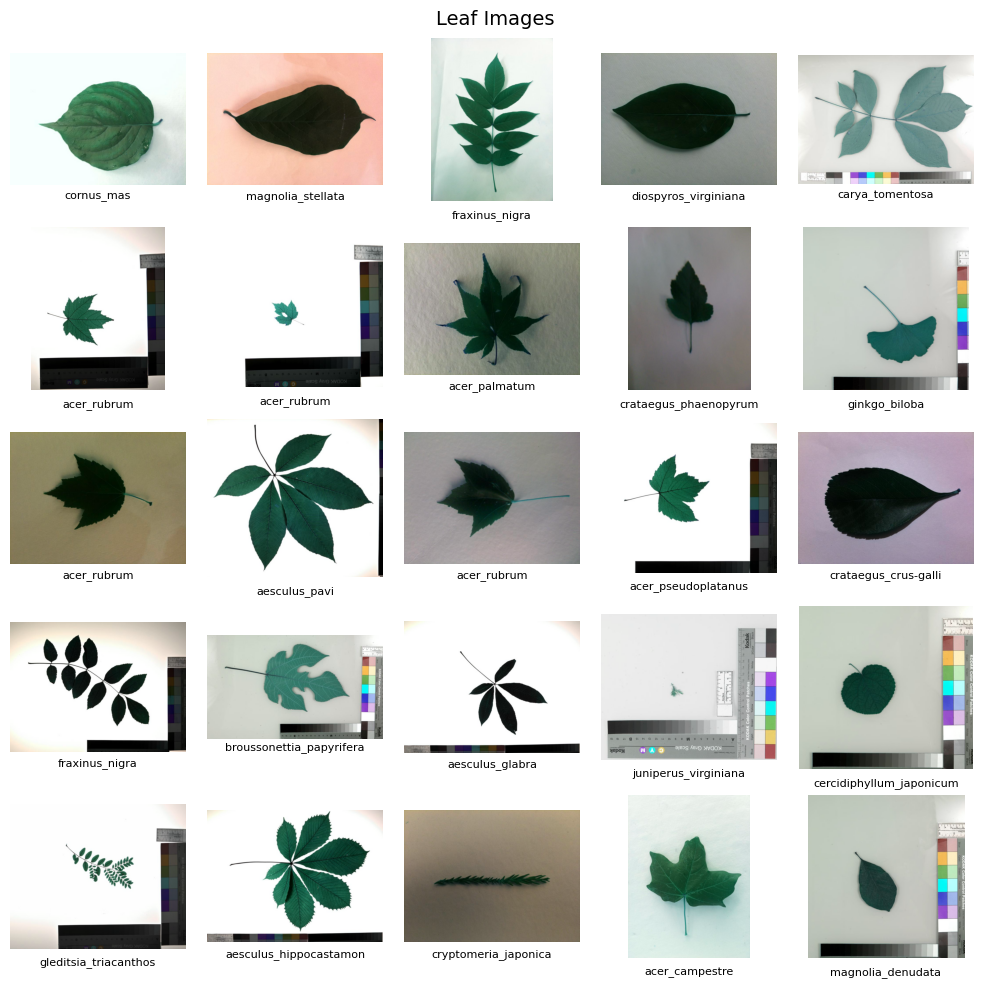

In [13]:
import random

im_paths = sds['image_path'].tolist()
random_paths = random.sample(im_paths, 25)
grid_size = (5, 5)
fig, axes = plt.subplots(figsize=(10, 10), nrows=5, ncols=5)

for i, path in enumerate(random_paths):
  img = cv2.imread(path)
  name = path.split('/')[-2]
  row = i//5
  col = i%5
  axes[row, col].imshow(img)
  axes[row, col].set_xticks([])
  axes[row, col].set_yticks([])
  axes[row, col].text(0.5, -0.1, name, fontsize=8, ha='center', transform=axes[row, col].transAxes)
  axes[row, col].axis('off')

plt.suptitle('Leaf Images', fontsize=14)
plt.tight_layout()
plt.show()

In [14]:
# filename = "/content/dataset/images/field/broussonettia_papyrifera/13001252070242.jpg"
# input_image = Image.open(filename)

In [15]:
# preprocess = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])
# input_tensor = preprocess(input_image)
# input_batch = input_tensor.unsqueeze(0)

In [16]:
import torch

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def load_and_preprocess_data(data):
    images = []
    labels = []
    count = 0
    for index, row in data.iterrows():
        img_path = row['image_path']
        image = Image.open(img_path)  # Use PIL to open the image
        image = preprocess(image)  # Apply the torchvision preprocessing transform
        count += 1
        images.append(image)
        labels.append(row['species_index'])
    # Convert lists to tensors
    images = torch.stack(images)
    labels = torch.tensor(labels)
    print(count)

    return images, labels

X, y = load_and_preprocess_data(sds)

10734


In [17]:
# np.save("/content/drive/MyDrive/test/X_cpu.npy", X)
# np.save("/content/drive/MyDrive/test/y_cpu.npy", y)

In [18]:
# # Save preprocessed data to Colab's temporary storage
# torch.save(X, '/content/Preprocessed_data/2datasets_X.pth')
# torch.save(y, '/content/Preprocessed_data/2datasets_y.pth')

In [19]:
# import gc

# X_cpu = X.cpu().numpy()
# np.save("/content/drive/MyDrive/test/X_cpu.npy", X_cpu)

# del X_cpu
# gc.collect()

In [20]:
# y_cpu = y.cpu().numpy()
# np.save("/content/drive/MyDrive/test/y_cpu.npy", y_cpu)

# del y_cpu
# gc.collect()

In [22]:
import gc

gc.collect()

10

In [23]:
# torch.cuda.empty_cache()

In [24]:
# X = np.load("/content/drive/MyDrive/test/X_cpu.npy")
# y = np.load("/content/drive/MyDrive/test/y_cpu.npy")

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

<Figure size 1500x480 with 0 Axes>

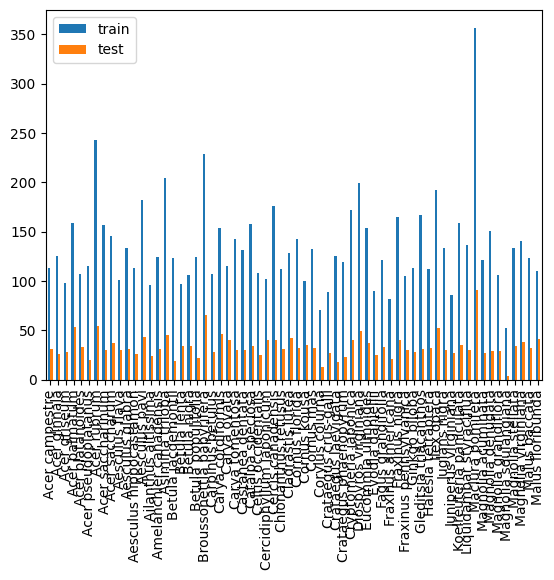

In [26]:
plt.figure().set_figwidth(15)
_, train_counts = np.unique(y_train, return_counts=True)
_, val_counts = np.unique(y_val, return_counts=True)
# Create a DataFrame for plotting
data = pd.DataFrame({'train': train_counts, 'test': val_counts}, index=classes_label)

# Plot the bar chart
data.plot.bar(width=0.6)

# Show the plot
plt.show()

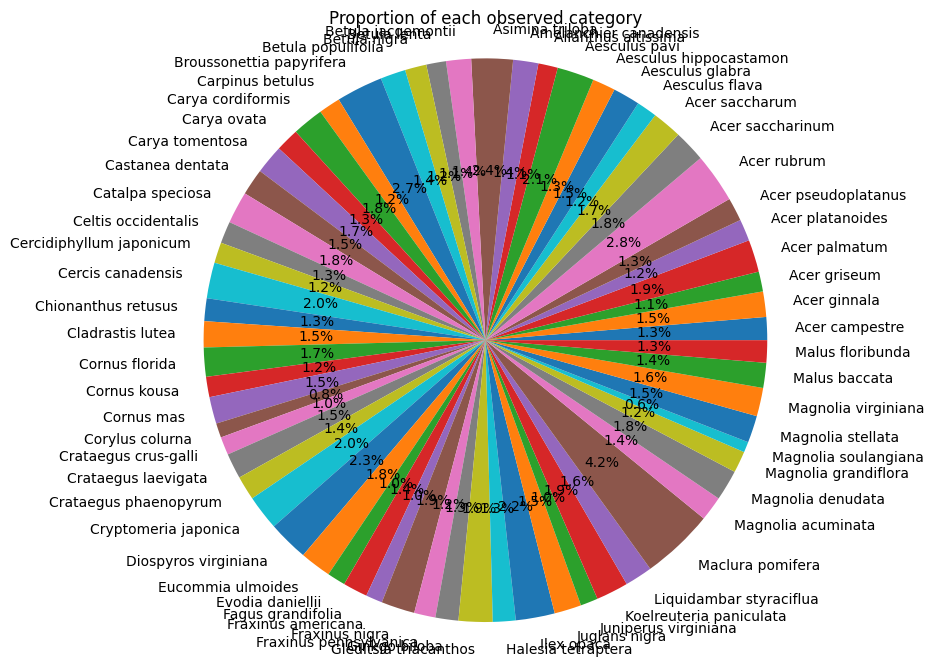

In [27]:
plt.figure(figsize=(8, 8))  # Adjust the width and height as needed
plt.pie(train_counts,
        explode=[0]*len(train_counts),
        labels=classes_label,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [28]:
model = torch.hub.load('facebookresearch/semi-supervised-ImageNet1K-models', 'resnext101_32x4d_ssl')
model.train()

Downloading: "https://github.com/facebookresearch/semi-supervised-ImageNet1K-models/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://dl.fbaipublicfiles.com/semiweaksupervision/model_files/semi_supervised_resnext101_32x4-dc43570a.pth" to /root/.cache/torch/hub/checkpoints/semi_supervised_resnext101_32x4-dc43570a.pth
100%|██████████| 169M/169M [00:02<00:00, 73.7MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [29]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [30]:
import torch.optim as optim

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [31]:
num_classes

64

In [32]:
y_train

tensor([12, 30, 61,  ..., 31,  5, 43])

In [33]:
from torch.utils.data import DataLoader, WeightedRandomSampler

# Assuming you have already defined your dataset class
# And the data is stored in X_train, X_val, y_train, y_val

# Calculate class weights
y_train_list = [int(label.item()) for label in y_train]

# Count the occurrences of each class label in y_train
#class_counts = Counter(y_train)  #if y is trained in cpu
class_counts = Counter(y_train_list)
total_samples = len(y_train)
class_weights = [total_samples / class_counts[class_label] for class_label in range(num_classes)]

In [34]:
print(min(class_counts.values()))

52


In [35]:
class_weights

[75.99115044247787,
 68.696,
 87.62244897959184,
 54.0062893081761,
 80.25233644859813,
 74.66956521739131,
 35.33744855967078,
 54.69426751592356,
 58.81506849315068,
 85.01980198019803,
 64.56390977443608,
 75.99115044247787,
 47.18131868131868,
 89.44791666666667,
 69.25,
 42.09313725490196,
 69.8130081300813,
 88.52577319587628,
 81.00943396226415,
 69.25,
 37.49781659388646,
 80.25233644859813,
 55.75974025974026,
 74.66956521739131,
 60.04895104895105,
 65.54961832061069,
 54.348101265822784,
 79.50925925925925,
 84.18627450980392,
 48.78977272727273,
 76.66964285714286,
 67.0859375,
 60.04895104895105,
 85.87,
 65.0530303030303,
 120.94366197183099,
 96.48314606741573,
 68.696,
 72.15966386554622,
 49.924418604651166,
 43.15075376884422,
 55.75974025974026,
 95.41111111111111,
 70.96694214876032,
 104.71951219512195,
 52.04242424242424,
 81.78095238095239,
 75.99115044247787,
 51.41916167664671,
 76.66964285714286,
 44.723958333333336,
 64.56390977443608,
 99.84883720930233,
 54

In [36]:
# Create sampler
sampler = WeightedRandomSampler(weights=class_weights, num_samples=total_samples, replacement=True)

In [37]:
from torch.utils.data import DataLoader, TensorDataset

# Assuming you have already prepared your training data: X_train, y_train
train_dataset = TensorDataset(X_train.clone().detach().to(torch.float32),
                              y_train.clone().detach().to(torch.long))

In [38]:
# Define your DataLoader with the created dataset
batch_size = 50  # You can adjust the batch size as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [39]:
from torch.utils.data import DataLoader, TensorDataset

# Assuming you have already prepared your validation data: X_val, y_val
val_dataset = TensorDataset(X_val.clone().detach().to(torch.float32),
                            y_val.clone().detach().to(torch.long))

# Define a DataLoader for validation data
val_batch_size = 32  # You can adjust this value as needed
val_loader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False)

In [40]:
# import torch

# # Save train_loader
# torch.save(train_loader, '/content/drive/MyDrive/test/train_loader.pth')

# # Save val_loader
# torch.save(val_loader, '/content/drive/MyDrive/test/val_loader.pth')


In [41]:
# import torch
# # Load train_loader
# train_loader = torch.load('/content/Preprocessed_data/train_loader.pth')

# # Load val_loader
# val_loader = torch.load('/content/Preprocessed_data/val_loader.pth')

In [42]:
num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # Training loop
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  # Zero the parameter gradients

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Update the model parameters
        optimizer.step()

        # Compute training loss
        running_loss += loss.item() * inputs.size(0)

        # Calculate the number of correct predictions
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()

        # Total number of samples
        total_samples += labels.size(0)

    # Calculate training epoch loss and accuracy
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct_predictions / total_samples

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.8f}, Training Accuracy: {epoch_accuracy:.8f}")

    # Validation loop
    with torch.no_grad():
        val_running_loss = 0.0
        val_correct_predictions = 0
        val_total_samples = 0

        for val_inputs, val_labels in val_loader:
          val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
          # Forward pass
          val_outputs = model(val_inputs)

          # Calculate the loss
          val_loss = criterion(val_outputs, val_labels)

          # Compute validation loss
          val_running_loss += val_loss.item() * val_inputs.size(0)

          # Calculate the number of correct predictions
          _, val_predicted = torch.max(val_outputs, 1)
          val_correct_predictions += (val_predicted == val_labels).sum().item()

          # Total number of samples
          val_total_samples += val_labels.size(0)

        # Calculate validation epoch loss and accuracy
        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_accuracy = val_correct_predictions / val_total_samples

        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_epoch_loss:.8f}, Validation Accuracy: {val_epoch_accuracy:.8f}")


Epoch 1/10, Training Loss: 1.28588960, Training Accuracy: 0.74438104
Epoch 1/10, Validation Loss: 0.30048836, Validation Accuracy: 0.91849092
Epoch 2/10, Training Loss: 0.10273867, Training Accuracy: 0.97484570
Epoch 2/10, Validation Loss: 0.14873171, Validation Accuracy: 0.96413600
Epoch 3/10, Training Loss: 0.03012976, Training Accuracy: 0.99487598
Epoch 3/10, Validation Loss: 0.09197478, Validation Accuracy: 0.97391709
Epoch 4/10, Training Loss: 0.01219553, Training Accuracy: 0.99836963
Epoch 4/10, Validation Loss: 0.06248964, Validation Accuracy: 0.98462972
Epoch 5/10, Training Loss: 0.00459951, Training Accuracy: 1.00000000
Epoch 5/10, Validation Loss: 0.05863198, Validation Accuracy: 0.98556125
Epoch 6/10, Training Loss: 0.00358954, Training Accuracy: 1.00000000
Epoch 6/10, Validation Loss: 0.05382298, Validation Accuracy: 0.98649278
Epoch 7/10, Training Loss: 0.00257566, Training Accuracy: 1.00000000
Epoch 7/10, Validation Loss: 0.05164010, Validation Accuracy: 0.98602701
Epoch 

In [43]:
# Set the model to evaluation mode
model.eval()

# Validation loop
with torch.no_grad():
    val_running_loss = 0.0
    val_correct_predictions = 0
    val_total_samples = 0

    for val_inputs, val_labels in val_loader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        # Forward pass
        val_outputs = model(val_inputs)

        # Calculate the loss
        val_loss = criterion(val_outputs, val_labels)

        # Compute validation loss
        val_running_loss += val_loss.item() * val_inputs.size(0)

        # Calculate the number of correct predictions
        _, val_predicted = torch.max(val_outputs, 1)
        val_correct_predictions += (val_predicted == val_labels).sum().item()

        # Total number of samples
        val_total_samples += val_labels.size(0)

    # Calculate validation epoch loss and accuracy
    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    val_epoch_accuracy = val_correct_predictions / val_total_samples

    print(f"Validation Loss: {val_epoch_loss:.8f}, Validation Accuracy: {val_epoch_accuracy:.8f}")

Validation Loss: 0.02604797, Validation Accuracy: 0.99394504


In [44]:
#set the model to train
model.train()
model.to(device)

num_epochs = 5

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # Training loop
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  # Zero the parameter gradients

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Update the model parameters
        optimizer.step()

        # Compute training loss
        running_loss += loss.item() * inputs.size(0)

        # Calculate the number of correct predictions
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()

        # Total number of samples
        total_samples += labels.size(0)

    # Calculate training epoch loss and accuracy
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct_predictions / total_samples

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.8f}, Training Accuracy: {epoch_accuracy:.8f}")

    # Validation loop
    with torch.no_grad():
        val_running_loss = 0.0
        val_correct_predictions = 0
        val_total_samples = 0

        for val_inputs, val_labels in val_loader:
          val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
          # Forward pass
          val_outputs = model(val_inputs)

          # Calculate the loss
          val_loss = criterion(val_outputs, val_labels)

          # Compute validation loss
          val_running_loss += val_loss.item() * val_inputs.size(0)

          # Calculate the number of correct predictions
          _, val_predicted = torch.max(val_outputs, 1)
          val_correct_predictions += (val_predicted == val_labels).sum().item()

          # Total number of samples
          val_total_samples += val_labels.size(0)

        # Calculate validation epoch loss and accuracy
        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_accuracy = val_correct_predictions / val_total_samples

        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_epoch_loss:.8f}, Validation Accuracy: {val_epoch_accuracy:.8f}")


Epoch 1/5, Training Loss: 0.00126734, Training Accuracy: 1.00000000
Epoch 1/5, Validation Loss: 0.04772828, Validation Accuracy: 0.98695855
Epoch 2/5, Training Loss: 0.00130480, Training Accuracy: 1.00000000
Epoch 2/5, Validation Loss: 0.04727847, Validation Accuracy: 0.98602701
Epoch 3/5, Training Loss: 0.00125638, Training Accuracy: 1.00000000
Epoch 3/5, Validation Loss: 0.04668654, Validation Accuracy: 0.98649278
Epoch 4/5, Training Loss: 0.00108507, Training Accuracy: 1.00000000
Epoch 4/5, Validation Loss: 0.04494739, Validation Accuracy: 0.98742431
Epoch 5/5, Training Loss: 0.00100587, Training Accuracy: 1.00000000
Epoch 5/5, Validation Loss: 0.04550411, Validation Accuracy: 0.98742431


In [45]:
# Set the model to evaluation mode
model.eval()

# Validation loop
with torch.no_grad():
    val_running_loss = 0.0
    val_correct_predictions = 0
    val_total_samples = 0

    for val_inputs, val_labels in val_loader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        # Forward pass
        val_outputs = model(val_inputs)

        # Calculate the loss
        val_loss = criterion(val_outputs, val_labels)

        # Compute validation loss
        val_running_loss += val_loss.item() * val_inputs.size(0)

        # Calculate the number of correct predictions
        _, val_predicted = torch.max(val_outputs, 1)
        val_correct_predictions += (val_predicted == val_labels).sum().item()

        # Total number of samples
        val_total_samples += val_labels.size(0)

    # Calculate validation epoch loss and accuracy
    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    val_epoch_accuracy = val_correct_predictions / val_total_samples

    print(f"Validation Loss: {val_epoch_loss:.8f}, Validation Accuracy: {val_epoch_accuracy:.8f}")

Validation Loss: 0.02409006, Validation Accuracy: 0.99394504


In [46]:
print(device)

cuda


In [47]:
# Define a file path to save the trained model
model_path = '/content/drive/MyDrive/test/trained_model.pth'

# Save the model's state dictionary
torch.save(model.state_dict(), model_path)

# Optionally, save other training-related information
optimizer_path = '/content/drive/MyDrive/test/optimizer.pth'
torch.save(optimizer.state_dict(), optimizer_path)

# Print a message indicating that the model has been saved
print(f"Model saved at: {model_path}")

Model saved at: /content/drive/MyDrive/test/trained_model.pth


In [49]:
# # Define the file path to load the saved model state dictionary
# model_path = '/content/drive/MyDrive/test/ntrained_model.pth'

# # Load the saved state dictionary
# model.load_state_dict(torch.load(model_path))

In [50]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [51]:
classes_label

array(['Acer campestre', 'Acer ginnala', 'Acer griseum', 'Acer palmatum',
       'Acer platanoides', 'Acer pseudoplatanus', 'Acer rubrum',
       'Acer saccharinum', 'Acer saccharum', 'Aesculus flava',
       'Aesculus glabra', 'Aesculus hippocastamon', 'Aesculus pavi',
       'Ailanthus altissima', 'Amelanchier canadensis', 'Asimina triloba',
       'Betula jacqemontii', 'Betula lenta', 'Betula nigra',
       'Betula populifolia', 'Broussonettia papyrifera',
       'Carpinus betulus', 'Carya cordiformis', 'Carya ovata',
       'Carya tomentosa', 'Castanea dentata', 'Catalpa speciosa',
       'Celtis occidentalis', 'Cercidiphyllum japonicum',
       'Cercis canadensis', 'Chionanthus retusus', 'Cladrastis lutea',
       'Cornus florida', 'Cornus kousa', 'Cornus mas', 'Corylus colurna',
       'Crataegus crus-galli', 'Crataegus laevigata',
       'Crataegus phaenopyrum', 'Cryptomeria japonica',
       'Diospyros virginiana', 'Eucommia ulmoides', 'Evodia daniellii',
       'Fagus grandifo

In [53]:
import io
import requests
from PIL import Image
from torchvision import transforms

# URL of the image you want to predict
image_url = "https://www.tree-guide.com/images/styles/600x450-copy_/public/silver-maple-leaf.jpg?itok=sk632gVj"
response = requests.get(image_url)
image = Image.open(io.BytesIO(response.content))

In [54]:
# filename = "/content/drive/MyDrive/test/acpa1280754.jpg"
# image = Image.open(filename)

In [55]:
print(device)

cuda


In [56]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(image)
input_tensor = input_tensor.to(device)
input_batch = input_tensor.unsqueeze(0)


model.eval()

# Perform inference
with torch.no_grad():
    output = model(input_batch)

In [57]:
# Convert the model's output into probabilities or class predictions
probabilities = torch.softmax(output, dim=1)
predicted_class = torch.argmax(probabilities, dim=1)
predicted_class

tensor([7], device='cuda:0')

In [58]:
print(classes_label[predicted_class[0]])

Acer saccharinum
